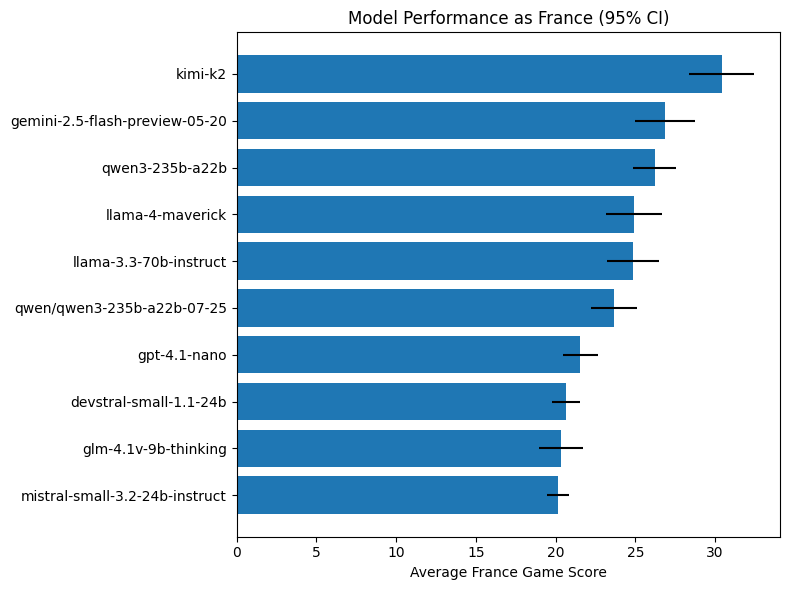

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# EDIT THE LIST BELOW: absolute or relative paths to your experiment folders
# Each folder should contain analysis/statistical_game_analysis/individual/*
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp080-bench": "kimi-k2",
    "../data/sam-exp081-bench": "mistral-small-3.2-24b-instruct",
    "../data/sam-exp082-bench": "devstral-small-1.1-24b",
    "../data/sam-exp083-bench": "gemini-2.5-flash-preview-05-20",
    "../data/sam-exp090-bench": "qwen3-235b-a22b",
    "../data/sam-exp091-bench": "llama-4-maverick",
    "../data/sam-exp092-bench": "gpt-4.1-nano",
    "../data/sam-exp105-bench": "glm-4.1v-9b-thinking",
    "../data/sam-exp106-bench": "llama-3.3-70b-instruct",
    "../data/sam-exp108-bench": "qwen/qwen3-235b-a22b-07-25",

}

# ---------------------------------------------------------------------------
# Collect France game_score values for each experiment
# ---------------------------------------------------------------------------
records = []
for exp_dir, label in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"
    csv_files = sorted(csv_dir.glob("run_*_game_analysis.csv"))
    
    scores = []
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            france_rows = df[df["power_name"] == "FRANCE"]
            if not france_rows.empty and "game_score" in france_rows.columns:
                scores.append(float(france_rows.iloc[0]["game_score"]))
        except Exception as exc:
            print(f"warning: {csv_file} – {exc}")
    
    scores_arr = np.asarray(scores, dtype=float)
    if scores_arr.size == 0:
        print(f"no France scores found for {exp_path}")
        continue
    
    mean_score = scores_arr.mean()
    if scores_arr.size > 1:
        sem = stats.sem(scores_arr, nan_policy="omit")
        ci_low, ci_high = stats.t.interval(0.95, scores_arr.size - 1, loc=mean_score, scale=sem)
    else:
        ci_low = ci_high = mean_score  # single sample
    
    records.append({
        "Label": label,
        "Mean": mean_score,
        "CI_low": ci_low,
        "CI_high": ci_high,
        "N": scores_arr.size,
    })

# ---------------------------------------------------------------------------
# Build summary DataFrame
# ---------------------------------------------------------------------------
summary_df = pd.DataFrame(records)
if summary_df.empty:
    raise RuntimeError("No data collected – check the paths and directory structure.")

# Sort by mean score (ascending for barh order)
summary_df = summary_df.sort_values("Mean").reset_index(drop=True)

#from ace_tools import display_dataframe_to_user
#display_dataframe_to_user("France game_score summary", summary_df[["Label", "Mean", "CI_low", "CI_high", "N"]])

# ---------------------------------------------------------------------------
# Plot horizontal bar chart with 95% CI error bars
# ---------------------------------------------------------------------------
plt.figure(figsize=(8, max(2, 0.6 * len(summary_df))))
y_pos = np.arange(len(summary_df))
xerr = [
    summary_df["Mean"] - summary_df["CI_low"],
    summary_df["CI_high"] - summary_df["Mean"],
]
plt.barh(y_pos, summary_df["Mean"], xerr=xerr, align="center")
plt.yticks(y_pos, summary_df["Label"])
plt.xlabel("Average France Game Score")
plt.title("Model Performance as France (95% CI)")
plt.tight_layout()
plt.show()